<a href="https://colab.research.google.com/github/FediBeltaief/plant_disease_app/blob/main/Plant_Leaf_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/plant_disease_project'
DATA_DIR = f'{BASE_DIR}/data'
MODEL_DIR = f'{BASE_DIR}/models'
PLOT_DIR = f'{BASE_DIR}/plots'
RESULTS_DIR = f'{BASE_DIR}/results'


Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow.keras.applications.efficientnet import preprocess_input
import random
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('float32')


In [ ]:
# Create directories if they don't exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-4

In [ ]:
# Print dataset structure
print("=" * 50)
print("DATASET STRUCTURE")
print("=" * 50)
train_path = f'{DATA_DIR}/train'
print(f'\nORIGINAL DATA:')
class_counts = {}
for cls in sorted(os.listdir(train_path)):
    cls_path = os.path.join(train_path, cls)
    if os.path.isdir(cls_path):
        count = len(os.listdir(cls_path))
        class_counts[cls] = count
        print(f"  {cls:<30} -> {count:>5} images")


DATASET STRUCTURE

ORIGINAL DATA:
  Potato___Early_blight          ->  1000 images
  Potato___Late_blight           ->  1000 images
  Potato___healthy               ->   152 images
  Tomato_Early_blight            ->  1000 images
  Tomato_Late_blight             ->  1909 images
  Tomato_healthy                 ->  1591 images


In [ ]:
# Load ALL data first
all_datagen = ImageDataGenerator(rescale=1./255)
all_data = all_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Get all file paths and labels
file_paths = all_data.filepaths
labels = all_data.classes
class_names = list(all_data.class_indices.keys())
num_classes = len(class_names)



Found 6652 images belonging to 6 classes.


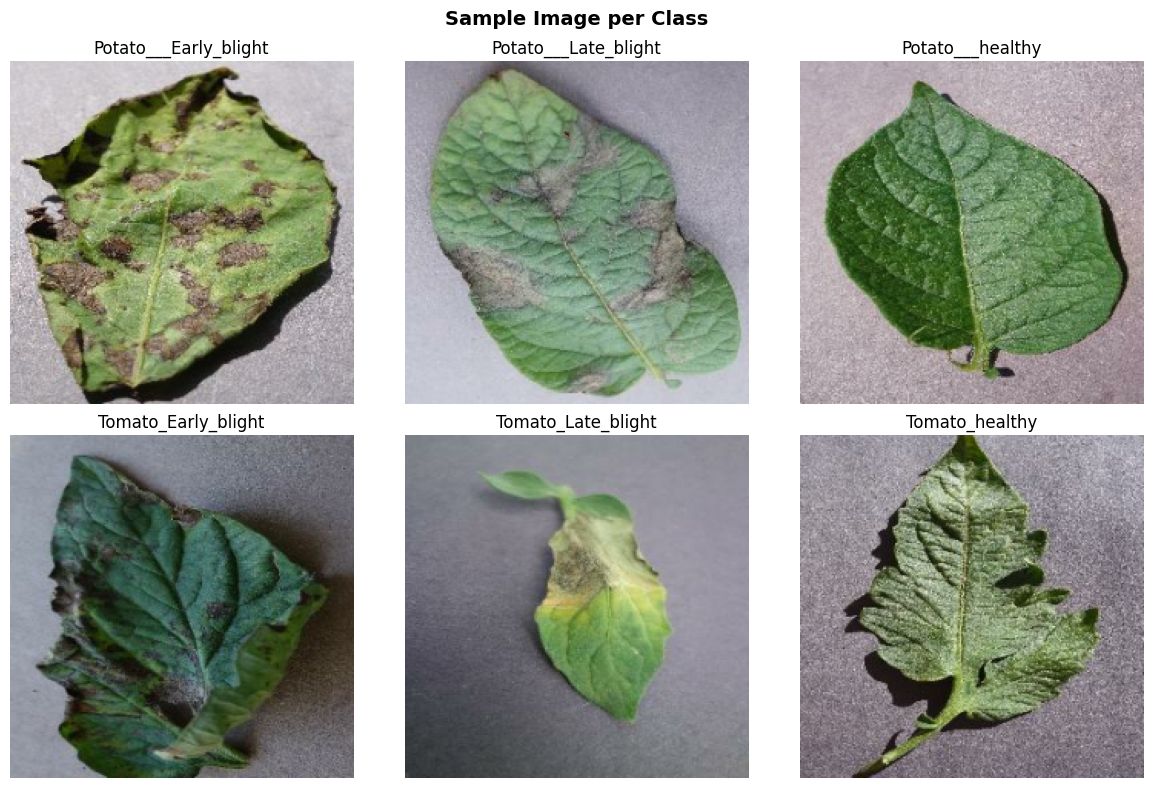

In [ ]:
class_to_idx = all_data.class_indices          # <-- THIS was missing
idx_to_class = {v: k for k, v in class_to_idx.items()}

all_files = np.array(all_data.filepaths)
all_labels = np.array(all_data.classes)

plt.figure(figsize=(12, 8))

for i, cls in enumerate(class_names):
    cls_idx = class_to_idx[cls]
    cls_files = all_files[all_labels == cls_idx]

    sample_path = random.choice(cls_files)

    img = tf.io.read_file(sample_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.uint8)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Sample Image per Class", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [ ]:

# Manual train/val/test split with stratification
# First split: 80% train, 20% temp (val+test)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Second split: Split temp into 50% val, 50% test (10% each of original)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

In [ ]:
#Data
print(f"\n{'=' * 50}")
print(f"DATASET SPLITS")
print(f"{'=' * 50}")
print(f"Training samples: {len(train_paths)} ({len(train_paths)/len(file_paths)*100:.1f}%)")
print(f"Validation samples: {len(val_paths)} ({len(val_paths)/len(file_paths)*100:.1f}%)")
print(f"Test samples: {len(test_paths)} ({len(test_paths)/len(file_paths)*100:.1f}%)")
print(f"Total: {len(file_paths)}")
print(f"\nClasses ({num_classes}): {class_names}")
print(f"{'=' * 50}\n")


DATASET SPLITS
Training samples: 5321 (80.0%)
Validation samples: 665 (10.0%)
Test samples: 666 (10.0%)
Total: 6652

Classes (6): ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']



In [ ]:
def create_dataset(file_paths, labels, augment=False, shuffle=False):
    def load_and_preprocess(path, label):
        # Load image
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = preprocess_input(img)

        # Augmentation for training
        if augment:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_flip_up_down(img)
            img = tf.image.random_brightness(img, 0.2)
            img = tf.image.random_contrast(img, 0.8, 1.2)

        # Convert label to one-hot
        label_onehot = tf.one_hot(label, num_classes)
        return img, label_onehot

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(len(file_paths))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [ ]:
train_dataset = create_dataset(train_paths, train_labels, augment=True, shuffle=True)
val_dataset = create_dataset(val_paths, val_labels, augment=False, shuffle=False)
test_dataset = create_dataset(test_paths, test_labels, augment=False, shuffle=False)

# Calculate class weights
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))

print("Class weights (to handle imbalance):")
for idx, cls in enumerate(class_names):
    print(f"  {cls}: {class_weights[idx]:.2f}")
print()

# Build model
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3)
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')
], name='PlantDiseaseClassifier')

model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_acc')]
)

print(model.summary())


Class weights (to handle imbalance):
  Potato___Early_blight: 1.11
  Potato___Late_blight: 1.11
  Potato___healthy: 7.33
  Tomato_Early_blight: 1.11
  Tomato_Late_blight: 0.58
  Tomato_healthy: 0.70

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "PlantDiseaseClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,843,433 (18.48 MB)

 Trainable params: 791,302 (3.02 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

None


In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint(
    f'{MODEL_DIR}/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True)

]

# Phase 1: Train with frozen base
print("\n" + "=" * 50)
print("PHASE 1: Training with frozen base model")
print("=" * 50 + "\n")

history_frozen = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Phase 2: Fine-tune
print("\n" + "=" * 50)
print("PHASE 2: Fine-tuning with unfrozen layers")
print("=" * 50 + "\n")

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Unfrozen {trainable_count}/{len(base_model.layers)} layers\n")

model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_acc')]
)

history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS - 10,
    callbacks=callbacks,
    class_weight=class_weights,
    initial_epoch=len(history_frozen.history['loss']),
    verbose=1
)
# Combine histories
history = {
    'accuracy': history_frozen.history['accuracy'] + history_finetune.history['accuracy'],
    'val_accuracy': history_frozen.history['val_accuracy'] + history_finetune.history['val_accuracy'],
    'loss': history_frozen.history['loss'] + history_finetune.history['loss'],
    'val_loss': history_frozen.history['val_loss'] + history_finetune.history['val_loss']
}


PHASE 1: Training with frozen base model

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1367s 8s/step - accuracy: 0.3995 - loss: 2.0109 - top_2_acc: 0.6087 - val_accuracy: 0.8015 - val_loss: 1.0866 - val_top_2_acc: 0.9398 - learning_rate: 1.0000e-04
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.7300 - loss: 1.1263 - top_2_acc: 0.8978 - val_accuracy: 0.8602 - val_loss: 0.8461 - val_top_2_acc: 0.9684 - learning_rate: 1.0000e-04
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.8156 - loss: 0.9767 - top_2_acc: 0.9425 - val_accuracy: 0.8887 - val_loss: 0.7801 - val_top_2_acc: 0.9820 - learning_rate: 1.0000e-04
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8408 - loss: 0.9357 - top_2_acc: 0.9541 - val_accuracy: 0.9008 - val_loss: 0.7694 - val_top_2_acc: 0.9835 - learning_rate: 1.0000e-04
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.8651 - loss: 0.8647 - top_2_acc: 0.9630 - val_accuracy: 0.9218 - val_loss: 0.7429 - v


Model saved to /content/drive/MyDrive/plant_disease_project/models/plant_disease_model_final.keras


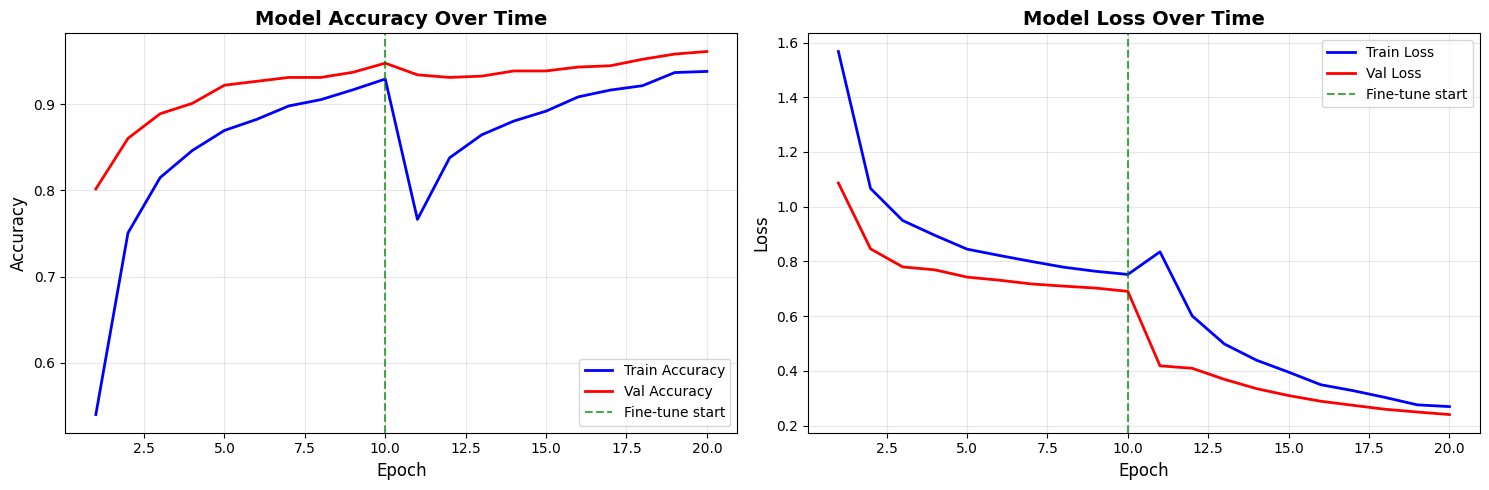

In [ ]:
# Save final model
model.save(f'{MODEL_DIR}/plant_disease_model_final.keras',save_format="keras",include_optimizer=False)
print(f"\nModel saved to {MODEL_DIR}/plant_disease_model_final.keras")

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
epochs_range = range(1, len(history['accuracy']) + 1)

axes[0].plot(epochs_range, history['accuracy'], 'b-', label='Train Accuracy', linewidth=2)
axes[0].plot(epochs_range, history['val_accuracy'], 'r-', label='Val Accuracy', linewidth=2)
axes[0].axvline(x=10, color='green', linestyle='--', alpha=0.7, label='Fine-tune start')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, history['loss'], 'b-', label='Train Loss', linewidth=2)
axes[1].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[1].axvline(x=10, color='green', linestyle='--', alpha=0.7, label='Fine-tune start')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{PLOT_DIR}/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()


VALIDATION SET EVALUATION

Validation Loss: 0.2406
Validation Accuracy: 96.09%
Validation Top-2 Accuracy: 99.70%

Generating validation predictions...


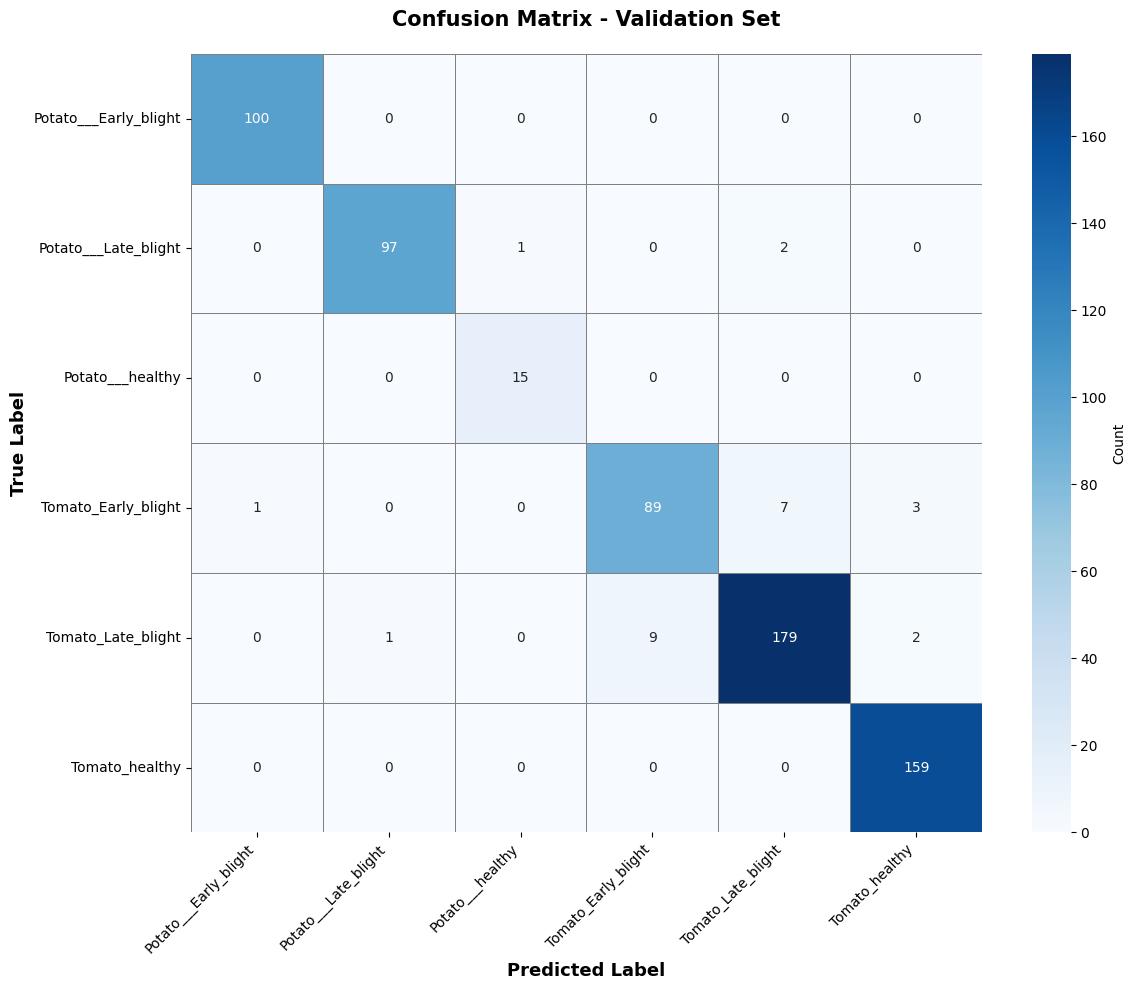


CLASSIFICATION REPORT - VALIDATION SET

                       precision    recall  f1-score   support

Potato___Early_blight     0.9901    1.0000    0.9950       100
 Potato___Late_blight     0.9898    0.9700    0.9798       100
     Potato___healthy     0.9375    1.0000    0.9677        15
  Tomato_Early_blight     0.9082    0.8900    0.8990       100
   Tomato_Late_blight     0.9521    0.9372    0.9446       191
       Tomato_healthy     0.9695    1.0000    0.9845       159

             accuracy                         0.9609       665
            macro avg     0.9579    0.9662    0.9618       665
         weighted avg     0.9607    0.9609    0.9607       665



In [ ]:
# ==================== VALIDATION EVALUATION ====================
print("\n" + "=" * 50)
print("VALIDATION SET EVALUATION")
print("=" * 50 + "\n")

val_loss, val_acc, val_top2 = model.evaluate(val_dataset, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Top-2 Accuracy: {val_top2*100:.2f}%")

# Get predictions for validation set
print("\nGenerating validation predictions...")
y_pred_val = []
y_true_val = []

for images, labels in val_dataset:
    preds = model.predict(images, verbose=0)
    y_pred_val.extend(np.argmax(preds, axis=1))
    y_true_val.extend(np.argmax(labels.numpy(), axis=1))

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)

# Validation confusion matrix
cm_val = confusion_matrix(y_true_val, y_pred_val)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_val,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray'
)
plt.xlabel("Predicted Label", fontsize=13, fontweight='bold')
plt.ylabel("True Label", fontsize=13, fontweight='bold')
plt.title("Confusion Matrix - Validation Set", fontsize=15, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{PLOT_DIR}/confusion_matrix_val.png', dpi=300, bbox_inches='tight')
plt.show()

# Validation classification report
report_val = classification_report(y_true_val, y_pred_val, target_names=class_names, digits=4)
print("\n" + "=" * 50)
print("CLASSIFICATION REPORT - VALIDATION SET")
print("=" * 50 + "\n")
print(report_val)

with open(f'{RESULTS_DIR}/classification_report_val.txt', 'w') as f:
    f.write(f"Plant Disease Classification - Validation Results\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("=" * 70 + "\n\n")
    f.write(f"Validation Accuracy: {val_acc*100:.2f}%\n")
    f.write(f"Validation Loss: {val_loss:.4f}\n\n")
    f.write(report_val)



TEST SET EVALUATION

21/21 ━━━━━━━━━━━━━━━━━━━━ 154s 7s/step - accuracy: 0.9727 - loss: 0.2023 - top_2_acc: 0.9974

Test Loss: 0.2218
Test Accuracy: 96.40%
Test Top-2 Accuracy: 99.70%

Generating test predictions...


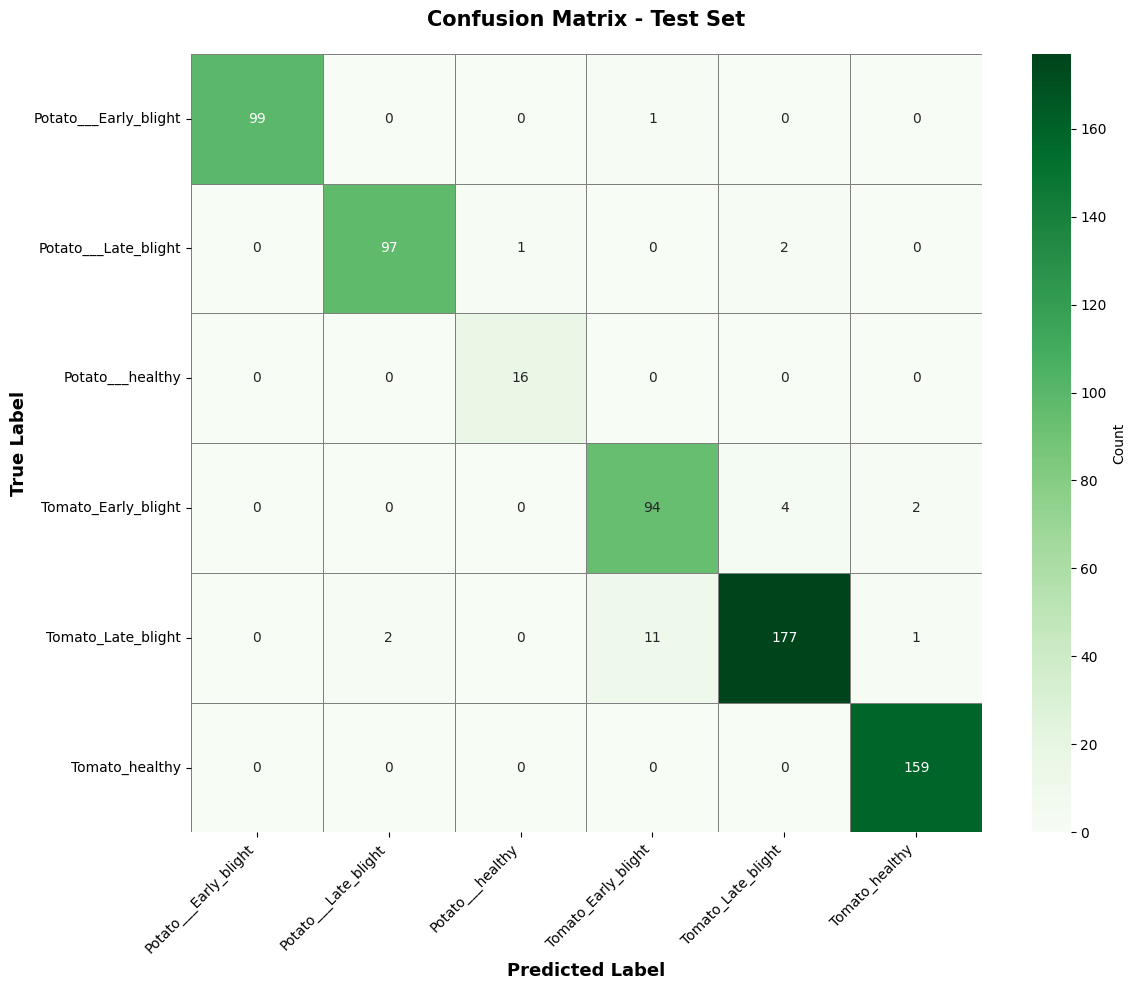


CLASSIFICATION REPORT - TEST SET

                       precision    recall  f1-score   support

Potato___Early_blight     1.0000    0.9900    0.9950       100
 Potato___Late_blight     0.9798    0.9700    0.9749       100
     Potato___healthy     0.9412    1.0000    0.9697        16
  Tomato_Early_blight     0.8868    0.9400    0.9126       100
   Tomato_Late_blight     0.9672    0.9267    0.9465       191
       Tomato_healthy     0.9815    1.0000    0.9907       159

             accuracy                         0.9640       666
            macro avg     0.9594    0.9711    0.9649       666
         weighted avg     0.9647    0.9640    0.9641       666



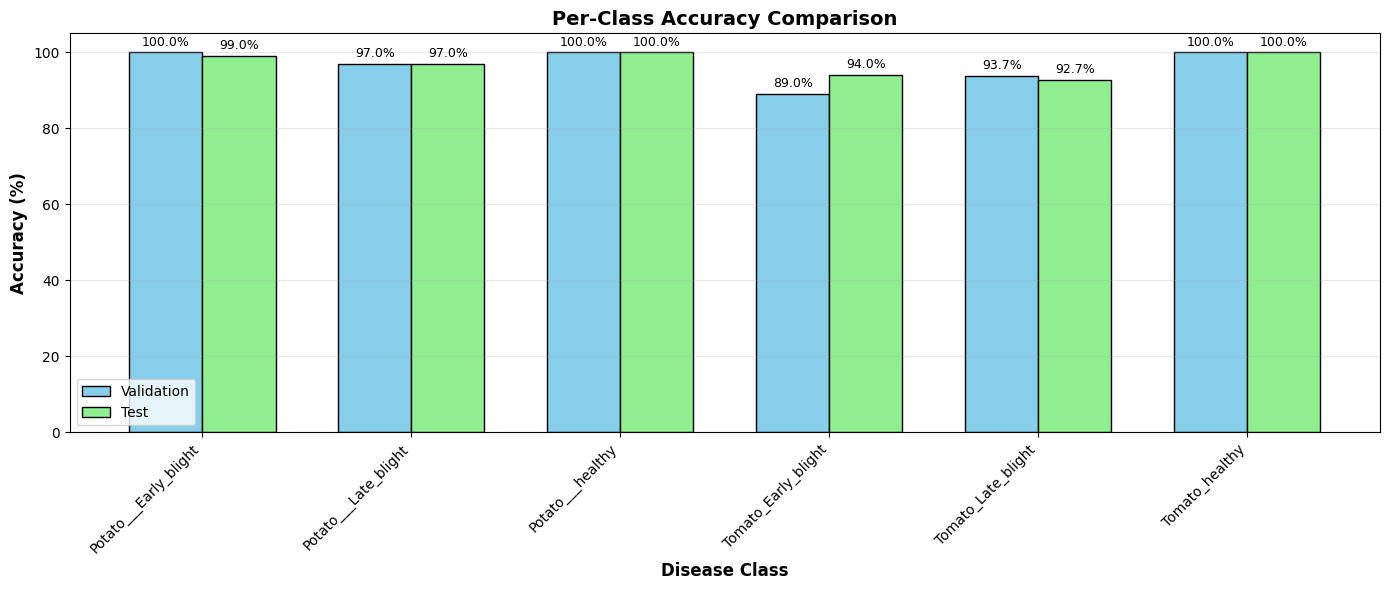


TRAINING COMPLETE - FINAL SUMMARY

Dataset:
  - Total images: 6652
  - Training: 5321 images (80.0%)
  - Validation: 665 images (10.0%)
  - Test: 666 images (10.0%)

Model Performance:
  - Validation Accuracy: 96.09%
  - Test Accuracy: 96.40%
  - Gap: 0.31%

Saved files:
  - Final model: /content/drive/MyDrive/plant_disease_project/models/plant_disease_model_final.keras
  - Best checkpoint: /content/drive/MyDrive/plant_disease_project/models/best_model.keras
  - Training curves: /content/drive/MyDrive/plant_disease_project/plots/training_curves.png
  - Val confusion matrix: /content/drive/MyDrive/plant_disease_project/plots/confusion_matrix_val.png
  - Test confusion matrix: /content/drive/MyDrive/plant_disease_project/plots/confusion_matrix_test.png
  - Per-class accuracy: /content/drive/MyDrive/plant_disease_project/plots/per_class_accuracy.png
  - Reports: /content/drive/MyDrive/plant_disease_project/results/



In [ ]:
# ==================== TEST EVALUATION ====================
print("\n" + "=" * 50)
print("TEST SET EVALUATION")
print("=" * 50 + "\n")

test_loss, test_acc, test_top2 = model.evaluate(test_dataset, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Top-2 Accuracy: {test_top2*100:.2f}%")

# Get predictions for test set
print("\nGenerating test predictions...")
y_pred_test = []
y_true_test = []

for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_pred_test.extend(np.argmax(preds, axis=1))
    y_true_test.extend(np.argmax(labels.numpy(), axis=1))

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)

# Test confusion matrix
cm_test = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_test,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray'
)
plt.xlabel("Predicted Label", fontsize=13, fontweight='bold')
plt.ylabel("True Label", fontsize=13, fontweight='bold')
plt.title("Confusion Matrix - Test Set", fontsize=15, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{PLOT_DIR}/confusion_matrix_test.png', dpi=300, bbox_inches='tight')
plt.show()

# Test classification report
report_test = classification_report(y_true_test, y_pred_test, target_names=class_names, digits=4)
print("\n" + "=" * 50)
print("CLASSIFICATION REPORT - TEST SET")
print("=" * 50 + "\n")
print(report_test)

with open(f'{RESULTS_DIR}/classification_report_test.txt', 'w') as f:
    f.write(f"Plant Disease Classification - Test Results\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("=" * 70 + "\n\n")
    f.write(f"Test Accuracy: {test_acc*100:.2f}%\n")
    f.write(f"Test Loss: {test_loss:.4f}\n\n")
    f.write(report_test)

# Per-class accuracy visualization
val_per_class_acc = cm_val.diagonal() / cm_val.sum(axis=1)
test_per_class_acc = cm_test.diagonal() / cm_test.sum(axis=1)

plt.figure(figsize=(14, 6))
x = np.arange(len(class_names))
width = 0.35

plt.bar(x - width/2, val_per_class_acc * 100, width, label='Validation', color='skyblue', edgecolor='black')
plt.bar(x + width/2, test_per_class_acc * 100, width, label='Test', color='lightgreen', edgecolor='black')

plt.xlabel('Disease Class', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Per-Class Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, class_names, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 105)

# Add value labels on bars
for i in range(len(class_names)):
    plt.text(i - width/2, val_per_class_acc[i] * 100 + 1, f'{val_per_class_acc[i]*100:.1f}%',
             ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, test_per_class_acc[i] * 100 + 1, f'{test_per_class_acc[i]*100:.1f}%',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f'{PLOT_DIR}/per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Save training history
np.save(f'{RESULTS_DIR}/training_history.npy', history)

# Final summary
print("\n" + "=" * 70)
print("TRAINING COMPLETE - FINAL SUMMARY")
print("=" * 70)
print(f"\nDataset:")
print(f"  - Total images: {len(file_paths)}")
print(f"  - Training: {len(train_paths)} images ({len(train_paths)/len(file_paths)*100:.1f}%)")
print(f"  - Validation: {len(val_paths)} images ({len(val_paths)/len(file_paths)*100:.1f}%)")
print(f"  - Test: {len(test_paths)} images ({len(test_paths)/len(file_paths)*100:.1f}%)")
print(f"\nModel Performance:")
print(f"  - Validation Accuracy: {val_acc*100:.2f}%")
print(f"  - Test Accuracy: {test_acc*100:.2f}%")
print(f"  - Gap: {abs(val_acc - test_acc)*100:.2f}%")
print(f"\nSaved files:")
print(f"  - Final model: {MODEL_DIR}/plant_disease_model_final.keras")
print(f"  - Best checkpoint: {MODEL_DIR}/best_model.keras")
print(f"  - Training curves: {PLOT_DIR}/training_curves.png")
print(f"  - Val confusion matrix: {PLOT_DIR}/confusion_matrix_val.png")
print(f"  - Test confusion matrix: {PLOT_DIR}/confusion_matrix_test.png")
print(f"  - Per-class accuracy: {PLOT_DIR}/per_class_accuracy.png")
print(f"  - Reports: {RESULTS_DIR}/")
print("=" * 70 + "\n")

In [ ]:
import tensorflow as tf
tf.__version__

'2.19.0'